<a href="https://colab.research.google.com/github/nagaichsid/causalML/blob/master/projects/marital_status_loan_defaults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are Two Heads Better Than One? Investigating Causal Relationships Between Marital Status and Loan Defaults

For Dr. Ness' Causal ML Workshop in Summer 2022

Authors: Shefali Khatri and Sid Nagaich

An example on how DoWhy can be used to estimate the effect of marital status on Loan Defaults. In this notebook, we use real-world data about Loan Defaults to estimate treatment effect for Marital Status on Risk Factor for Defaulting on Loans. We will further look at the differences in treatment effects between groups based on income.

## Background

The most common types of consumer loans are mortgage, auto loan, education loan, personal loan, refinance loan, and credit card. Individuals who default on these loans are a risk to the lender, so lenders use a variety of factors to determine whether or not it is risky to approve such loans.

In this notebook, we look specifically at the effects of marital status on default risk. A lender could consider whether your spouse has an ability to provide additional coverage in the event of a nonpayment. We also hypothesize that married couples are potentially more meticulous about financial risks, as failure to repay a loan has an impact on not only oneself for these couples.

![](https://images.unsplash.com/photo-1607863680198-23d4b2565df0?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80)

## Benefits of Understanding the Causal Mechanisms

Suppose that a new individual signs up for a loan. How do we know the individual won't default? Here the relevant causal question is:

What is the impact of marital status on the likeliehood of a loan default?

And the equivalent counterfactual question is:

If the individual had not been married, how likely is it that they would have otherwise experienced a loan default?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT). 

## Proposed Scenario
A lender, such as a bank, wants to know how marital status affects the risk of defaulting on a potential loan.

A direct interventional study is infeasible because a bank cannot force customers to get married. Likewise, the bank can’t look directly at existing data of married customers and non-married customers, because the customers who choose to take a loan likely already skews heavily towards those who are married. Thus, the bank needs a causal model that can evaluate the causal effect through an intervention.

## Proposed Solution
The DoWhy library can help build a causal model, identify the causal effect and test causal assumptions.

## Data

The dataset can be found at https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior?select=Training+Data.csv. The goal of our investigation is to evaluate how income, home ownership, and car ownership may be causally related to whether an individual defaults on a loan and conversely, how defaulting on a loan may be causally related to home or car ownership. We will conduct this analysis by estimating the average treatment effect (ATE) and conditional average treatment effect (CATE) to evaluate the causal relationship between loan defaults and home ownership, car ownership, and income. Our first step in evaluating the impact of these factors is to theorize how these factors may be related to each other and develop Causal DAGs that reflect our domain knowledge. Below we propose a Causal DAG that represents our assumptions about how income is causally related to loan defaults. We also evaluated whether a history of loan default is causally related to the lack of home or car ownership by income to evaluate how individuals in different income groups may be affected differently by loan defaults. Before we construct the Causal DAG, we import the data and perform data cleaning.

For our project we are using Loan Prediction data from kaggle that contains 252,000 observations. We summarise the variables used for this case study in the table below:

| Variable Name | Type | Details |
| --- | --- | --- |
|Marital Status|Treatment|Married/Single|
|Risk_Flag|Outcome|At Risk for Default of Consumer Loan?|
|Income|Covariate of Interest|Income (Indian Rupees)|
|Age|Covariate|Age|
|Experience|Covariate|Years of Work Experience|
|House Ownership|Covariate|Owns a Home?|
|Car Ownership|Covariate|Owns a Car?|
|Profession|Covariate|Work Occupation|
|City|Covariate|City|
|State|Covariate|State|
|Years in Current Job|Covariate|Years in Current Job|
|Years in Current House|Covariate|Years in Current House|


We first load the data via Kaggle's API for analysis.

## Import Data via Kaggle API

Installation of required libraries not included in a Colab runtime:

In [1]:
%%capture
!pip install kaggle
!pip install pgmpy
!pip install pygraphviz
!pip install dowhy

Import all needed libraries:

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import os
import networkx as nx
import graphviz
from IPython.display import Image, display
from dowhy import CausalModel
import dowhy.gcm as gcm
from pathlib import Path
from pgmpy.base.DAG import DAG

import warnings
warnings.filterwarnings("ignore")

We use Kaggle's API to access and download the data, then we unzip it to a local directory.

In [3]:
# your api key
api_key = {
'username':"neusnagaich" ,
'key':"5eca26127ba98bcfacb91b6d9716df50"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)  

In [4]:
%%capture
!kaggle datasets download subhamjain/loan-prediction-based-on-customer-behavior
!unzip loan-prediction-based-on-customer-behavior.zip

## Inspecting and Cleaning the Data
In this section, we inspect our loaded data and clean it as needed. 

The home ownership column has 3 categories and therefore would be converted into 3 classes, by default. To convert this into a binary variable, rented ownership status is changed to no ownership. In our data cleaning process, we encode categorical variables using n-hot encoding

In [5]:
## Import Data
df = pd.read_csv('Training Data.csv')

# Fix Ownership column
def change_ownership(ownership_status):
  if ownership_status == "rented":
    return "norent_noown"
  return ownership_status

# Apply Fix 
df['House_Ownership'] = df['House_Ownership'].apply(change_ownership)

# Cleaning Data
def cleanData(df):
  # grab headers
  headers = [h for h in df.columns]

  # these columns contain numeric data
  n_cols = df[headers].select_dtypes(include=np.number).columns.tolist()
  print("\nnumeric columns: ", n_cols)

  # these columns contain categorical data
  c_cols = df[headers].select_dtypes('object').columns.tolist()
  print("\ncategorical columns: ", c_cols)

  # encode categorical data using pandas 
  df[c_cols] = df[c_cols].astype('category')
  df[c_cols] = df[c_cols].apply(lambda x: x.cat.codes)

  # replace missing data with the average of the column
  df = df.fillna(df.mean())

# clean data
cleanData(df)


numeric columns:  ['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag']

categorical columns:  ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']


Here we visualize the cleaned data

In [6]:
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,1,0,0,33,251,13,3,13,0
1,2,7574516,40,10,1,0,0,43,227,14,9,13,0
2,3,3991815,66,4,0,0,0,47,8,12,4,10,0
3,4,6256451,41,2,1,0,1,43,54,17,2,12,1
4,5,5768871,47,11,1,0,0,11,296,22,3,14,1


We note that our data was compiled using stratified sampling of income groups, leaving us with a roughly uniform distribution of income. This is not representative of our population, but we will be using the uniform amounts of data to better compare between income buckets, as we will also sample from these stratified groups.

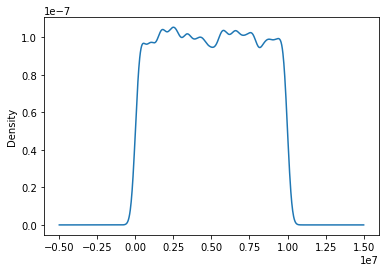

In [7]:
df['Income'].plot.kde();

## Step 1: Create Causal Model
We define causal assumptions with DoWhy. For example, we can include features we believe as common causes and instrumental variables. With these assumptions defined, DoWhy can generate a causal graph, and we can use that graph to identify the causal effect.

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


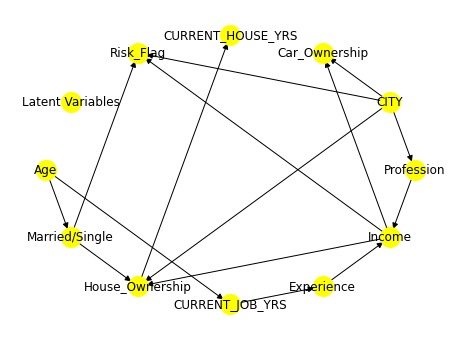

In [22]:
# Build the causal DAG.
dot = graphviz.Digraph()

dot.node('Age', 'Age')
dot.node('Married/Single', 'Married/Single')
dot.node('House_Ownership', 'House_Ownership')
dot.node('CURRENT_JOB_YRS', 'CURRENT_JOB_YRS')
dot.node('Experience', 'Experience')
dot.node('Income', 'Income')
dot.node('House_Ownership', 'House_Ownership')
dot.node('Profession', 'Profession')
dot.node('CITY', 'CITY')
dot.node('Car_Ownership', 'Car_Ownership')
dot.node('CURRENT_HOUSE_YRS', 'CURRENT_HOUSE_YRS')
dot.node('Risk_Flag', 'Risk_Flag')
dot.node('Latent Variables', 'Latent Variables')

dot.edge('Age','Married/Single')
dot.edge('Married/Single','House_Ownership')
dot.edge('Age','CURRENT_JOB_YRS')
dot.edge('CURRENT_JOB_YRS','Experience')
dot.edge('Experience','Income')
dot.edge('Income','House_Ownership')
dot.edge('Profession','Income')
dot.edge('CITY', 'Profession')
dot.edge('CITY', 'Car_Ownership')
dot.edge('CITY', 'House_Ownership')
dot.edge('Income', 'Car_Ownership')
dot.edge('House_Ownership', 'CURRENT_HOUSE_YRS')
dot.edge('Married/Single', 'Risk_Flag')
dot.edge('Income', 'Risk_Flag')
dot.edge('CITY', 'Risk_Flag')
    

model = CausalModel(
    data=df,
    graph = dot.source.replace("\t", " ").replace("\n", ' '),
    treatment=['Married/Single'],
    outcome=["Risk_Flag"],
    instruments =['Age'])
model.view_model();

## Step 2: Identify Estimand

We identify the causal effect that we are interested in between Married/Single and Risk_Flag

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                    
─────────────────(Expectation(Risk_Flag|Age))
d[Married/Single]                            
Estimand assumption 1, Unconfoundedness: If U→{Married/Single} and U→Risk_Flag then P(Risk_Flag|Married/Single,Age,U) = P(Risk_Flag|Married/Single,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Step 3: Calculate Effect of Marital Status on Risk Flag
We use linear regression to calculate the average treatment effect.

In [10]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        confidence_intervals=True)

print(causal_estimate_reg)
print("The causal effect estimate is " + str(round(causal_estimate_reg.value, 4)))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': ['Experience', 'CITY', 'CURRENT_JOB_YRS', 'Income', 'Profession']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Experience', 'CITY', 'CURRENT_JOB_YRS', 'Income', 'Profession']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Experience', 'CITY', 'CURRENT_JOB_YRS', 'Income', 'Profession']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['Experience', 'CITY', 'CURRENT_JOB_YRS', 'Income', 'Profession

## Step 4: Refute Estimand
Here we attempt to test the robustness of our estimand. If a future user wishes to demonstrate a more thorough examination of the estimand, one could utilize the following refutation methods on all observed CATEs across the income groups.

### Add Random Common Cause
How robust are our estimates to adding a confounder?

In [ ]:
res_random = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                   method_name="random_common_cause", num_simulations=10)
print(res_random)

### Add Unobserved Common Cause
How robust are our estimates to unobserved confounders? 

In [ ]:
res_unobserved = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                       method_name="add_unobserved_common_cause",
                                       confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                       effect_strength_on_treatment=0.05, effect_strength_on_outcome=0.5)
print(res_unobserved)

### Replace Treatment with a Random (Placebo) Variable
What happens to our estimate if we replace the treatment with noise?

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10)
print(res_placebo)

### Remove a Random Subset of the Data
Do we observe similar estimates on subsets of the data?

In [ ]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate_reg,
                                  method_name="data_subset_refuter", subset_fraction=0.8, 
                                    num_simulations=10)
print(res_subset)

# Further Analysis: Conditioning the Treatment Effect on Income

First we simplify our causal graph of Marital Status (the treatment $T$), Risk Flag (the outcome $Y$), and control variables $W$. We adjust for assuming that they block all back-door paths between $Y$ and $T$, and income $X$ (the covariate of interest based on which we want to study the heterogeneity of treatment effect).

In [13]:
# treatment is Loan Default status
treatment_var = "Married/Single"
# outcome is Income
outcome_var = "Risk_Flag"

# Remove treatment/outcome from list of all columns
headers = [h for h in df.columns]
headers.remove('Married/Single')
headers.remove('Risk_Flag')
# Use this as list of covariates
covariates = headers

# draw edges assuming no interactions between covariates (may want to further study/model)
edges = [(treatment_var, outcome_var)]
edges.extend([(covariate, treatment_var) for covariate in covariates])
edges.extend([(covariate, outcome_var) for covariate in covariates])

causal_graph = nx.DiGraph(edges)

Here we created a simplified graph where there are no interactions between covariates (i.e. nodes in $X \cup W$). This is not the case in actuality. However, since we take joint samples of the covariates directly from the data to later estimate CATEs, we can ignore their interactions.

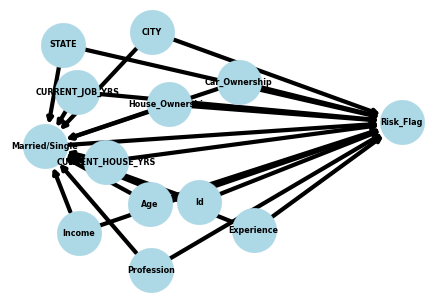

In [15]:
gcm.util.plot(causal_graph)

We assign causal models to variables.  We fit empirical distributions. For the treatment variable, we assign a classifier functional causal model (FCM) with a random forest classifier. For the outcome variable, we assign an additive noise model with a random forest classification as a function and empirical distribution for the noise.  We assign empirical distributions to all covariates.

In [16]:
causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.ClassifierFCM(gcm.ml.create_random_forest_classifier()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_classifier()))
for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

To fit a classifier FCM, we cast the treatment column to string type.

In [ ]:
df = df.astype({treatment_var: str})

With that, we can now fit the learn the causal models from data.

In [ ]:
gcm.fit(causal_model, df)

Fitting causal mechanism of node CURRENT_HOUSE_YRS: 100%|██████████| 13/13 [01:50<00:00,  8.48s/it]


Before computing CATE, we first divide subjects into bins of income percentiles. This allows us to study the impact on various income groups.

In [ ]:
percentages = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_edges = [0]
bin_edges.extend(np.quantile(df.Income, percentages[1:]).tolist())
bin_edges[-1] += 1 # adding 1 to the last edge as last edge is excluded by np.digitize

groups = [f'{percentages[i]*100:.0f}%-{percentages[i+1]*100:.0f}%' for i in range(len(percentages)-1)]
group_index_to_group_label = dict(zip(range(1, len(bin_edges)+1), groups))

Now we compute Conditional Average Treatment Effect (CATE). We perform a randomised intervention on the treatment variable in the fitted causal graph, draw samples from the interventional distribution, group observations by the income group, and finally compute the treatment effect in each group. 

In [ ]:
np.random.seed(42)

def estimate_cate():
    samples = gcm.interventional_samples(causal_model, 
                                         {treatment_var: lambda x: np.random.choice(['0', '1'])},
                                         observed_data=df)
    eligible = samples[treatment_var] == '1'
    ate = samples[eligible][outcome_var].mean() - samples[~eligible][outcome_var].mean()
    result = dict(ate = ate)
    
    group_indices = np.digitize(samples['Income'], bin_edges)
    samples['group_index'] = group_indices
    
    for group_index in group_index_to_group_label:
        group_samples = samples[samples['group_index'] == group_index]
        eligible_in_group = group_samples[treatment_var] == '1'
        cate = group_samples[eligible_in_group][outcome_var].mean() - group_samples[~eligible_in_group][outcome_var].mean()
        result[group_index_to_group_label[group_index]] = cate
        
    return result

group_to_median, group_to_ci = gcm.confidence_intervals(estimate_cate, num_bootstrap_resamples=100)
print(group_to_median)
print(group_to_ci)

Estimating boostrap interval...: 100%|██████████| 100/100 [23:34<00:00, 14.15s/it]

{'ate': 0.08559544976415374, '0%-20%': 0.08666928115057027, '20%-40%': 0.07978938486675906, '40%-60%': 0.08180811237489234, '60%-80%': 0.08255103475499215, '80%-100%': 0.0971455537582202}
{'ate': array([0.08435052, 0.08680084]), '0%-20%': array([0.08296557, 0.08957134]), '20%-40%': array([0.07727236, 0.08295174]), '40%-60%': array([0.07930905, 0.08440282]), '60%-80%': array([0.07982208, 0.0855877 ]), '80%-100%': array([0.09459002, 0.10030626])}


The average treatment effect of Marital Status on Risk for Defaulting is positive as indicated by our confidence intervals. We next plot CATEs of various income groups to gain more insights.

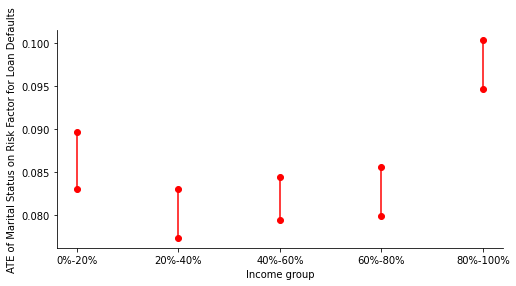

In [ ]:
fig = plt.figure(figsize=(8,4))
for x, group in enumerate(groups):
    ci = group_to_ci[group]
    plt.plot((x, x), (ci[0], ci[1]), 'ro-', color='red')
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(len(groups)), groups)
plt.xlabel('Income group')
plt.ylabel('ATE of Marital Status on Risk Factor for Loan Defaults')
plt.show()

The impact is highest for the highest earners. This lends credibility to our hypothesis that married couples are potentially more meticulous about financial risks. Risky financial decisions in married couples would affect more than only oneself, leading to more meticulous planning and the avoidance of such risks. Furthermore, risky financial decisions in high income groups would likely lead to more significant impacts on quality of life due to the magnitude of money being affected.
